# Predicting Churn

In this mini-project, you're going to work for a telecom company. This company wants to know which of its customers are likely to churn so they can target them and keep their business.

As the data scientist assigned to this project, you have two goals:
1. Predict which customers are going to churn
2. Predict what the company can do to try to keep more customers



# Summary

**In this cell, write your boss a short summary of what you did, what you found, and why it is important.**

Our model will allow us to address 60% of customer churn. This could have a massive impact on the company's bottom line. Our research revealed that customer tenure is the #1 predictor of customer retention: Customers that stay with the company for at least 24 months are half as likely to cancel their service as customers with shorter tenure. Initial research suggests that we can reduce churn by 10% if we can get customers to stay for another 6 months. The second most impactful predictor of customer churn is the monthly charges to the customer: Statistically, customers who cancel their service are billed $13 more per month than those that continue service. Reducing churn by approximately 10% would require discounts of 20-30%. We do not have reason to believe that any other variable is predictive of customer retention on its own.

# Import Packages

In [1]:
# import packages here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data

In [2]:
# DO NOT CHANGE THIS CELL!
data = pd.read_csv('/content/drive/MyDrive/cca_ds/Videos/Week6/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
# take a look at the data
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# fix any immediate issues, such as dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**In this cell, give your first thoughts on the data. What does each column mean? Which column are we trying to predict? What challenges do you foresee?**

Most of these columns appear to be binary, but changing them may not be that simple. The `MultipleLines` column is hierarchically nested within the `PhoneService` column. Off the top of my head, I'm not sure what the best way to handle that would be.

We are trying to model the `Churn` column. The hard part is going to be figuring out how to deal with preprocessing the columns.

# Data Exploration and Preprocessing

**You have free rein here. You've done this enough by this point that you can handle it! If you get stuck, you can always look at my solution for ideas.**

In [5]:
# explore and preprocess the data for modeling
# HINT: Start with what's easy

In [6]:
# I'm going to start by splitting off a test set
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=1)

In [7]:
# I want to make most if not all columns binary, zeros and ones
# I can use a OneHotEncoder for that.
# But there is at least one hierarchically nested column, so let me deal with
# that first
train[['PhoneService', 'MultipleLines']]
train['PhoneLines'] = 0
train.loc[train['PhoneService'] == 'Yes', 'PhoneLines'] = 1
train.loc[train['MultipleLines'] == 'Yes', 'PhoneLines'] = 2
train[['PhoneService', 'MultipleLines', 'PhoneLines']]

,PhoneService,MultipleLines,PhoneLines
1814,Yes,No,1
5946,Yes,No,1
3881,Yes,Yes,2
2389,Yes,Yes,2
3676,Yes,No,1
...,...,...,...
905,Yes,Yes,2
5192,Yes,No,1
3980,Yes,Yes,2
235,Yes,Yes,2


In [8]:
# I want a function to do this for me next time
def get_phonelines(df):
  df['PhoneLines'] = 0
  df.loc[df['PhoneService'] == 'Yes', 'PhoneLines'] = 1
  df.loc[df['MultipleLines'] == 'Yes', 'PhoneLines'] = 2
  df = df.drop(columns = ['PhoneService', 'MultipleLines'])
  return df

In [9]:
# cool now get rid of the columns that I replaced
# with the PhoneLines column
train.drop(columns = ['PhoneService', 'MultipleLines'], inplace=True)
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PhoneLines
1814,5442-PPTJY,Male,0,Yes,Yes,12,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.70,258.35,No,1
5946,6261-RCVNS,Female,0,No,No,42,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,3160.55,Yes,1
3881,2176-OSJUV,Male,0,Yes,No,71,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,4681.75,No,2
2389,6161-ERDGD,Male,0,Yes,Yes,71,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,6300.85,No,2
3676,2364-UFROM,Male,0,No,No,30,DSL,Yes,Yes,No,Yes,Yes,No,One year,No,Electronic check,70.40,2044.75,No,1


In [10]:
# A whole bunch of columns are hierarchically nested under the
# InternetService column. I can't think of a good way to handle
# that many hierarchical relationships and I can't find any info
# on the internet about how other people approached it, so
# I'm just going to say "No internet service" is the same as "No"
train.loc[train['OnlineSecurity'] == 'No internet service', 'OnlineSecurity'] = 'No'
train.loc[train['OnlineBackup'] == 'No internet service', 'OnlineBackup'] = 'No'
train.loc[train['DeviceProtection'] == 'No internet service', 'DeviceProtection'] = 'No'
train.loc[train['TechSupport'] == 'No internet service', 'TechSupport'] = 'No'
train.loc[train['StreamingTV'] == 'No internet service', 'StreamingTV'] = 'No'
train.loc[train['StreamingMovies'] == 'No internet service', 'StreamingMovies'] = 'No'

train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,PhoneLines
1814,5442-PPTJY,Male,0,Yes,Yes,12,No,No,No,No,No,No,No,Two year,No,Mailed check,19.70,258.35,No,1
5946,6261-RCVNS,Female,0,No,No,42,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,3160.55,Yes,1
3881,2176-OSJUV,Male,0,Yes,No,71,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,4681.75,No,2
2389,6161-ERDGD,Male,0,Yes,Yes,71,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,6300.85,No,2
3676,2364-UFROM,Male,0,No,No,30,DSL,Yes,Yes,No,Yes,Yes,No,One year,No,Electronic check,70.40,2044.75,No,1


In [11]:
# function to make the "No internet service" columns binary
def no_internet(df):
  columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
  for column in columns:
    df.loc[df[column] == 'No internet service', column] = 'No'
  return df

In [12]:
# No I'm going to check how many unique values each column has
# and decide what to do about them
train.nunique()

,0
customerID,5634
gender,2
SeniorCitizen,2
Partner,2
Dependents,2
tenure,73
InternetService,3
OnlineSecurity,2
OnlineBackup,2
DeviceProtection,2


In [13]:
# a lot of the column are already binary, which is great.
# customerID is unique (as it should be) and TotalCharges is almost unique, too
# Anything that has more than 2 values but less than 100,
# I want to explore further before deciding what to do.
train['tenure']
# this column is the number of months that the subscription has been
# active, I think. I'm going to leave it, and probably send it through a
# StandardScaler along with MonthlyCharges adn TotalCharges

,tenure
1814,12
5946,42
3881,71
2389,71
3676,30
...,...
905,9
5192,60
3980,28
235,2


In [14]:
train['InternetService'].value_counts()
# this column just needs to be OneHotEncoded

,count
InternetService,
Fiber optic,2479
DSL,1934
No,1221


In [15]:
train['Contract'].value_counts()
# this column also just needs to be one-hot encoded

,count
Contract,
Month-to-month,3104
Two year,1344
One year,1186


In [16]:
train['PaymentMethod'].value_counts()
# also just one-hot encoded

,count
PaymentMethod,
Electronic check,1893
Mailed check,1305
Bank transfer (automatic),1219
Credit card (automatic),1217


In [17]:
train['Churn'].value_counts()
# I want to change this column to 0s and 1s
# I'm going to do it by hand instead of with the one-hot encoder

,count
Churn,
No,4113
Yes,1521


In [18]:
# change Churn to 0s and 1s
# I am doing it this way so that if there are rows
# where the Churn column is ANYTHING other than "Yes",
# the Target will be 0 (no churn)
# I like this because it is explicit. Anyone reading this knows what
# the output is going to be.
train['Target'] = 0
train.loc[train['Churn'] == 'Yes', 'Target'] = 1
train['Target'].value_counts()

,count
Target,
0,4113
1,1521


In [19]:
# function to make the Target
def make_target(df):
  df['Target'] = 0
  df.loc[df['Churn'] == 'Yes', 'Target'] = 1
  df = df.drop(columns = ['Churn'])
  return df

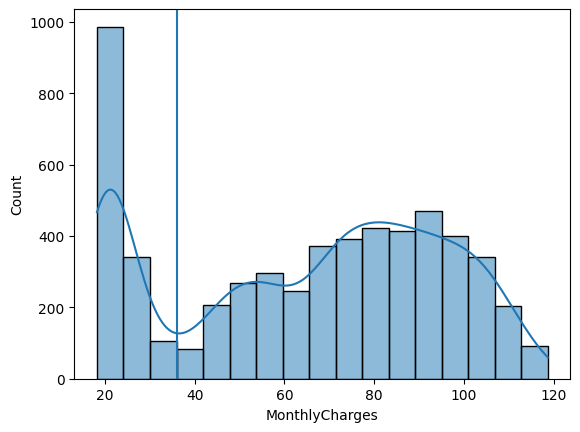

In [20]:
# now check the numeric features
sns.histplot(train['MonthlyCharges'], kde=True)
plt.axvline(36)
# I think I want to split this feature...
# Okay, a new feature, a bucket feature, with 0 if MonthlyCharges < 35
# and 1 if MonthlyCharges >= 35
# But that's it. With the two features combined, it should be
# summetrical enough to not cause problems

In [21]:
# make the new MonthlyUnder35 feature
train['MonthlyUnder35'] = 0
train.loc[train['MonthlyCharges'] >= 35, 'MonthlyUnder35'] = 1
train['MonthlyUnder35'].value_counts()

,count
MonthlyUnder35,
1,4243
0,1391


In [22]:
# final feature! TotalCharges
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')
train['TotalCharges'] = train['TotalCharges'].fillna(0)
# there's a freaking non-numeric value in here. Sheesh.
# I gotta fix that

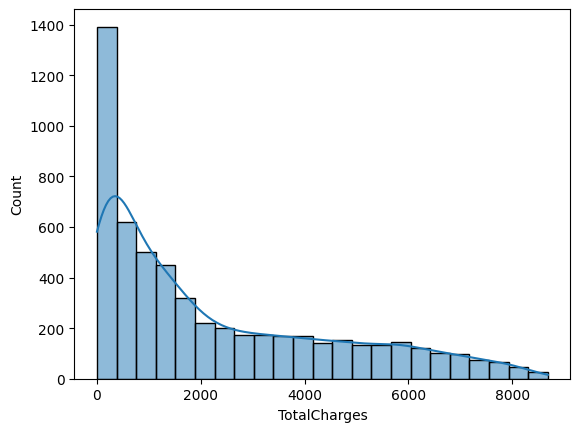

In [23]:
# now look at a histogram
sns.histplot(train['TotalCharges'], kde=True);
# this column is not symmetrical. I would prefer that it be symmetrical.
# I'm going to try a sqrt or log transformation.

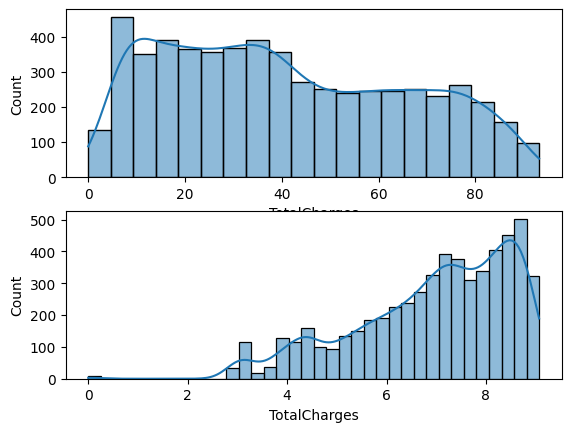

In [24]:
# check transformations
fig, ax = plt.subplots(nrows=2)
sns.histplot(np.sqrt(train['TotalCharges']), kde=True, ax=ax[0])
sns.histplot(np.log(train['TotalCharges'] + 1), kde=True, ax=ax[1]);
# the sqrt transformation is the good one. I'll do that.

In [25]:
# function to deal with the TotalCharges column
def sqrt_totalcharges(df):
  df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
  df['TotalCharges'] = df['TotalCharges'].fillna(0)
  df['TotalCharges'] = np.sqrt(df['TotalCharges'])
  return df

In [26]:
def preprocess_data(df):
  df = get_phonelines(df)
  df = no_internet(df)
  df = make_target(df)
  df = sqrt_totalcharges(df)
  return df

In [27]:
# I have decided to use a Pipeline to group together
# encoding, scaling, and modeling, so I can tune all the hyperparameters
# and exchange scalers/encoders as I feel like.
# Your steps here are likely to be different from mine!

# refresh the `train` dataframe to test the function
train = data.loc[train.index, :].copy()
train = preprocess_data(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5634 entries, 1814 to 5157
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5634 non-null   object 
 1   gender            5634 non-null   object 
 2   SeniorCitizen     5634 non-null   int64  
 3   Partner           5634 non-null   object 
 4   Dependents        5634 non-null   object 
 5   tenure            5634 non-null   int64  
 6   InternetService   5634 non-null   object 
 7   OnlineSecurity    5634 non-null   object 
 8   OnlineBackup      5634 non-null   object 
 9   DeviceProtection  5634 non-null   object 
 10  TechSupport       5634 non-null   object 
 11  StreamingTV       5634 non-null   object 
 12  StreamingMovies   5634 non-null   object 
 13  Contract          5634 non-null   object 
 14  PaperlessBilling  5634 non-null   object 
 15  PaymentMethod     5634 non-null   object 
 16  MonthlyCharges    5634 non-null   float64
 1

# Fit a Baseline Model

In [28]:
# choose a baseline and fit it on the training set
# DO NOT PREDICT THE TEST SET YET!

# import from sklearn
from sklearn.dummy import DummyClassifier

In [29]:
# I'm checking for imbalance in the training set
# to determine what kind of Baseline I want
train['Target'].value_counts(normalize=True)

,proportion
Target,
0,0.730032
1,0.269968


In [30]:
# The most useful Baseline is probably strategy='stratified'
# but baselines are easy to make, so I'm going to make four of them.
# Since I'm not going to explore the business implications of actions
# taken on the predictions, I'm not going to use a
# constant=1 baseline (assuming everyone is going to churn)
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(train.drop(columns=['customerID', 'Target']),
                   train['Target'])
stratified = DummyClassifier(strategy='stratified')
stratified.fit(train.drop(columns=['customerID', 'Target']),
               train['Target'])
prior = DummyClassifier(strategy='prior')
prior.fit(train.drop(columns=['customerID', 'Target']),
          train['Target'])
uniform = DummyClassifier(strategy='uniform')
uniform.fit(train.drop(columns=['customerID', 'Target']),
            train['Target']);

# Choose a Model (or several Models!) to Tune

In [31]:
# what kind of model do you think will work well on this data?
# import models!

# I generally like to start with a simple model, like Linear Regression
# or in this case, Logistic Regression (for classification)
from sklearn.linear_model import LogisticRegression

# I don't know if a random forest or support vector classifier will
# work better for this data. So I'll try both!
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# KNN is often used to predict churn, so I'll try that one too
from sklearn.neighbors import KNeighborsClassifier

# Since I'm going to use a Pipeline with a encoding and scaling,
# I need to import that stuff
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (StandardScaler, OneHotEncoder)

# this one is needed because sometimes the people who
# create sci-kit learn make very stupid decisions
from sklearn.compose import ColumnTransformer

# Pick a Hyperparameter Tuning Method

In [32]:
# The two we saw in the video are GridSearchCV
# and RandomizedSearchCV.
# Pick one of those (or something more exciting!)
# to use to tune your hyperparameters

# Since I'm doing multiple models, I'm going to use
# RandomizedSearchCV to keep things from getting out of hand.
from sklearn.model_selection import RandomizedSearchCV

# I want to use scipy distributions also
from scipy.stats import uniform

In [33]:
train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,PhoneLines,Target
1814,5442-PPTJY,Male,0,Yes,Yes,12,No,No,No,No,No,No,No,Two year,No,Mailed check,19.70,16.073270,1,0
5946,6261-RCVNS,Female,0,No,No,42,DSL,Yes,Yes,Yes,Yes,No,Yes,One year,No,Credit card (automatic),73.90,56.218769,1,1
3881,2176-OSJUV,Male,0,Yes,No,71,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Bank transfer (automatic),65.15,68.423315,2,0
2389,6161-ERDGD,Male,0,Yes,Yes,71,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,85.45,79.377894,2,0
3676,2364-UFROM,Male,0,No,No,30,DSL,Yes,Yes,No,Yes,Yes,No,One year,No,Electronic check,70.40,45.218912,1,0


# Tune Hyperparameters!

In [34]:
# Now tune the hyperparameters!
# Pick some values or distributions to try
# and run the test! Keep in mind how many combinations you're testing
# These can get really big really fast, so watch out!

numeric_columns = ['tenure', 'MonthlyCharges', 'TotalCharges', 'PhoneLines']
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies', 'Contract', 'PaperlessBilling',
                       'PaymentMethod']
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])
categorical_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessing_transformer = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_columns),
    ('categorical', categorical_pipeline, categorical_columns)
])

pipe1 = Pipeline([
    ('preprocessing', preprocessing_transformer),
    ('model', LogisticRegression())
])
pipe2 = Pipeline([
    ('preprocessing', preprocessing_transformer),
    ('model', RandomForestClassifier())
])
pipe3 = Pipeline([
    ('preprocessing', preprocessing_transformer),
    ('model', SVC())
])
pipe4 = Pipeline([
    ('preprocessing', preprocessing_transformer),
    ('model', KNeighborsClassifier())
])

In [35]:
# hyperparameters
pipe1_params = {
    'preprocessing__categorical__encoder__drop': ['first', 'if_binary', None],
    'preprocessing__categorical__encoder__min_frequency': uniform(loc=0.01, scale=0.25),
    'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'model__C': uniform(loc=0, scale=10),
    'model__fit_intercept': [True, False],
    'model__class_weight': ['balanced', None],
}

# fit logistic regression pipeline
logreg_cv = RandomizedSearchCV(pipe1, pipe1_params, n_iter=100, verbose=3)
logreg_cv.fit(train.drop(columns=['customerID', 'Target']),
              train['Target'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__C=6.027362496526444, model__class_weight=None, model__fit_intercept=True, model__penalty=none, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.039951190683465664;, score=nan total time=   0.1s
[CV 2/5] END model__C=6.027362496526444, model__class_weight=None, model__fit_intercept=True, model__penalty=none, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.039951190683465664;, score=nan total time=   0.2s
[CV 3/5] END model__C=6.027362496526444, model__class_weight=None, model__fit_intercept=True, model__penalty=none, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.039951190683465664;, score=nan total time=   0.2s
[CV 4/5] END model__C=6.027362496526444, model__class_weight=None, model__fit_intercept=True, model__penalty=none, preprocessing__catego

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
350 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
85 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/usr/local/lib/py

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'PhoneLines']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurit...
                   param_distributions={'model__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78226a94c160>,
                                        'model__class_weight': ['balanced',
                                                                None],
                                        'model__fit_intercept': [True, False],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'none'],
                                        'preprocessing__categorical__encoder__drop': ['first',
                                                                                      'if_binary',
                                                                                      None],
                                        'preprocessing__categorical__encoder__min_frequency': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782269f40a00>},
                   verbose=3)

In [36]:
logreg_cv.best_score_

0.8022694999692671

In [37]:
# hyperparameters
pipe2_params = {
    'preprocessing__categorical__encoder__drop': ['first', 'if_binary', None],
    'preprocessing__categorical__encoder__min_frequency': uniform(loc=0.01, scale=0.25),
    'model__max_depth': [2, 5, 10, 20, None],
    'model__min_samples_leaf': [1, 2, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__n_estimators': [10, 50, 100, 200],
    'model__max_features': uniform(loc=0, scale=1),
    'model__class_weight': ['balanced', None],
}

# fit logistic regression pipeline
rfc_cv = RandomizedSearchCV(pipe2, pipe2_params, n_iter=100, verbose=3)
rfc_cv.fit(train.drop(columns=['customerID', 'Target']),
           train['Target'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__class_weight=balanced, model__max_depth=None, model__max_features=0.2843771046383803, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=100, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__encoder__min_frequency=0.25347855597250835;, score=0.774 total time=   0.5s
[CV 2/5] END model__class_weight=balanced, model__max_depth=None, model__max_features=0.2843771046383803, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=100, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__encoder__min_frequency=0.25347855597250835;, score=0.787 total time=   0.5s
[CV 3/5] END model__class_weight=balanced, model__max_depth=None, model__max_features=0.2843771046383803, model__min_samples_leaf=5, model__min_samples_split=2, model__n_estimators=100, preprocessing__categorical__encoder__drop=if_binary, preprocessin

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'PhoneLines']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurit...
                                        'model__max_features': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782270e3ed40>,
                                        'model__min_samples_leaf': [1, 2, 5, 10,
                                                                    20],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     20],
                                        'model__n_estimators': [10, 50, 100,
                                                                200],
                                        'preprocessing__categorical__encoder__drop': ['first',
                                                                                      'if_binary',
                                                                                      None],
                                        'preprocessing__categorical__encoder__min_frequency': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x782270e3d780>},
                   verbose=3)

In [38]:
rfc_cv.best_score_

0.7974770725341647

In [39]:
# hyperparameters
pipe3_params = {
    'preprocessing__categorical__encoder__drop': ['first', 'if_binary', None],
    'preprocessing__categorical__encoder__min_frequency': uniform(loc=0.01, scale=0.25),
    'model__gamma': uniform(loc=0, scale=1),
    'model__C': uniform(loc=0, scale=1),
    'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'model__class_weight': ['balanced', None],
    'model__shrinking': [True, False]
}

# fit logistic regression pipeline
svc_cv = RandomizedSearchCV(pipe3, pipe3_params, n_iter=100, verbose=3)
svc_cv.fit(train.drop(columns=['customerID', 'Target']),
           train['Target'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__C=0.8583608617099533, model__class_weight=None, model__gamma=0.48476742348717095, model__kernel=rbf, model__shrinking=True, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.10948480794900879;, score=0.786 total time=   0.8s
[CV 2/5] END model__C=0.8583608617099533, model__class_weight=None, model__gamma=0.48476742348717095, model__kernel=rbf, model__shrinking=True, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.10948480794900879;, score=0.786 total time=   0.7s
[CV 3/5] END model__C=0.8583608617099533, model__class_weight=None, model__gamma=0.48476742348717095, model__kernel=rbf, model__shrinking=True, preprocessing__categorical__encoder__drop=first, preprocessing__categorical__encoder__min_frequency=0.10948480794900879;, score=0.792 total time=   0.7s
[CV 4/5] END model__C=0.8583608617099533, mode

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'PhoneLines']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurit...
                                        'model__gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7822b53c4250>,
                                        'model__kernel': ['linear', 'poly',
                                                          'rbf', 'sigmoid'],
                                        'model__shrinking': [True, False],
                                        'preprocessing__categorical__encoder__drop': ['first',
                                                                                      'if_binary',
                                                                                      None],
                                        'preprocessing__categorical__encoder__min_frequency': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7822b53c4610>},
                   verbose=3)

In [40]:
svc_cv.best_score_

0.7988980316815892

In [41]:
# hyperparameters
pipe4_params = {
    'preprocessing__categorical__encoder__drop': ['first', 'if_binary', None],
    'preprocessing__categorical__encoder__min_frequency': uniform(loc=0.01, scale=0.25),
    'model__n_neighbors': [1, 2, 5, 10, 20, 50, 100],
    'model__weights': ['uniform', 'distance'],
    'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'model__p': [1, 2, 5, 10]
}

# fit logistic regression pipeline
knn_cv = RandomizedSearchCV(pipe4, pipe4_params, n_iter=100, verbose=3)
knn_cv.fit(train.drop(columns=['customerID', 'Target']),
           train['Target'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__algorithm=auto, model__n_neighbors=100, model__p=5, model__weights=uniform, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__encoder__min_frequency=0.08449521902858696;, score=0.791 total time=   2.3s
[CV 2/5] END model__algorithm=auto, model__n_neighbors=100, model__p=5, model__weights=uniform, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__encoder__min_frequency=0.08449521902858696;, score=0.781 total time=   2.0s
[CV 3/5] END model__algorithm=auto, model__n_neighbors=100, model__p=5, model__weights=uniform, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__encoder__min_frequency=0.08449521902858696;, score=0.799 total time=   1.7s
[CV 4/5] END model__algorithm=auto, model__n_neighbors=100, model__p=5, model__weights=uniform, preprocessing__categorical__encoder__drop=if_binary, preprocessing__categorical__e

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['tenure',
                                                                                'MonthlyCharges',
                                                                                'TotalCharges',
                                                                                'PhoneLines']),
                                                                              ('categorical',
                                                                               Pipeline(steps=[('encoder',
                                                                                                OneHotEncoder())]),
                                                                               ['gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'InternetService',
                                                                                'OnlineSecurit...
                   param_distributions={'model__algorithm': ['auto',
                                                             'ball_tree',
                                                             'kd_tree',
                                                             'brute'],
                                        'model__n_neighbors': [1, 2, 5, 10, 20,
                                                               50, 100],
                                        'model__p': [1, 2, 5, 10],
                                        'model__weights': ['uniform',
                                                           'distance'],
                                        'preprocessing__categorical__encoder__drop': ['first',
                                                                                      'if_binary',
                                                                                      None],
                                        'preprocessing__categorical__encoder__min_frequency': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7822b53c4df0>},
                   verbose=3)

In [42]:
knn_cv.best_score_

0.7974789637841391

# Compare Models and Baseline

In [43]:
# import metrics from sklearn
from sklearn.metrics import (classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             accuracy_score, recall_score, precision_score,
                             roc_auc_score, RocCurveDisplay)

In [50]:
# preprocess test data
processed_test = preprocess_data(test)

In [51]:
# let's look at classification reports first
best_models = {'LogisticRegression': logreg_cv,
               'RandomForestClassifier': rfc_cv,
               'SVC': svc_cv,
               'KNeighborsClassifier': knn_cv}
for name, model in best_models.items():
  print(name)
  print(classification_report(processed_test['Target'], model.predict(processed_test.drop(columns=['customerID', 'Target']))))

LogisticRegression
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1061
           1       0.66      0.56      0.61       348

    accuracy                           0.82      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409

RandomForestClassifier
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1061
           1       0.65      0.55      0.59       348

    accuracy                           0.82      1409
   macro avg       0.76      0.73      0.74      1409
weighted avg       0.81      0.82      0.81      1409

SVC
              precision    recall  f1-score   support

           0       0.86      0.91      0.88      1061
           1       0.65      0.54      0.59       348

    accuracy                           0.82      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.81     

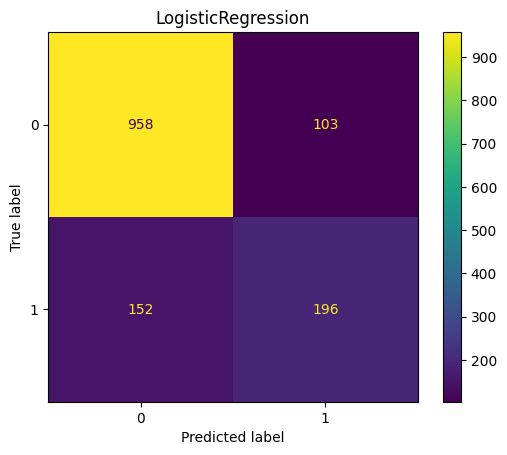

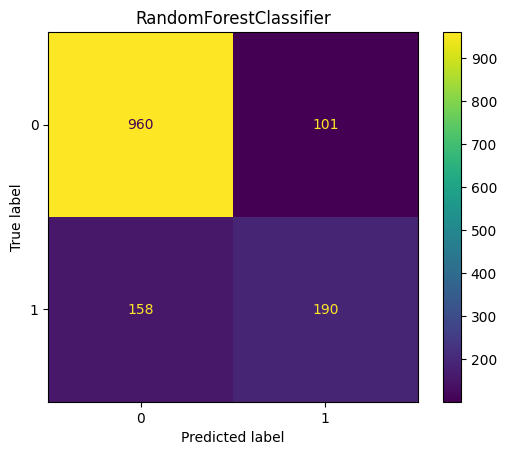

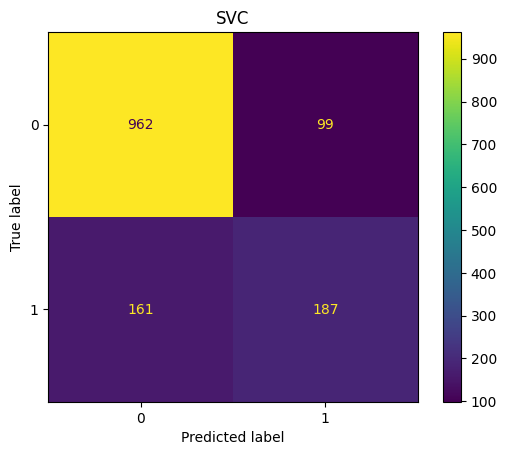

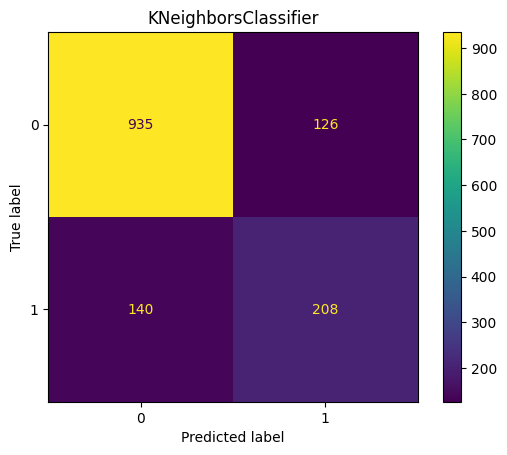

In [53]:
# confusion matrix displays
for name, model in best_models.items():
  ConfusionMatrixDisplay.from_estimator(model, processed_test.drop(columns=['customerID', 'Target']), processed_test['Target'])
  plt.title(name);

In [54]:
# calculate metrics
metrics_df = pd.DataFrame(columns=['model', 'accuracy', 'recall', 'precision', 'roc_auc'])
for name, model in best_models.items():
  acc = accuracy_score(processed_test['Target'], model.predict(processed_test.drop(columns=['customerID', 'Target'])))
  rec = recall_score(processed_test['Target'], model.predict(processed_test.drop(columns=['customerID', 'Target'])))
  prec = precision_score(processed_test['Target'], model.predict(processed_test.drop(columns=['customerID', 'Target'])))
  roc = roc_auc_score(processed_test['Target'], model.predict(processed_test.drop(columns=['customerID', 'Target'])))
  metrics_df.loc[len(metrics_df)] = [name, acc, rec, prec, roc]

In [55]:
# look at the dataframe
metrics_df

,model,accuracy,recall,precision,roc_auc
0,LogisticRegression,0.819021,0.563218,0.655518,0.733070
1,RandomForestClassifier,0.816182,0.545977,0.652921,0.725392
2,SVC,0.815472,0.537356,0.653846,0.722024
3,KNeighborsClassifier,0.811214,0.597701,0.622754,0.739473


<ipython-input-64-530c018f2e9c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
<ipython-input-64-530c018f2e9c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
<ipython-input-64-530c018f2e9c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
<ipython-input-64-530c018f2e9c>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)


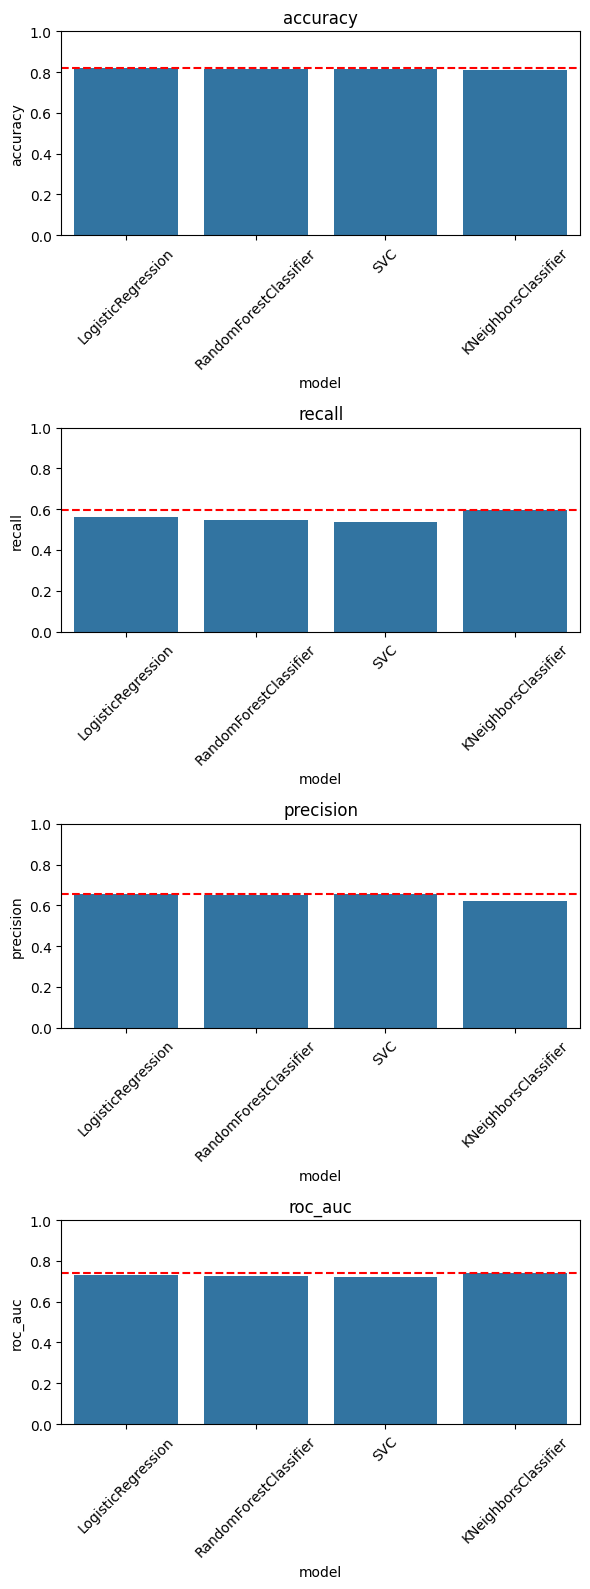

In [64]:
# bar charts of metrics
fig, ax = plt.subplots(nrows=4, figsize=(6,16))
for i, col in enumerate(metrics_df.columns[1:]):
  sns.barplot(x='model', y=col, data=metrics_df, ax=ax[i])
  ax[i].set_ylim(0, 1)
  ax[i].set_title(col)
  ax[i].axhline(y=metrics_df[col].max(), linestyle='dashed', color='red')
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45)
fig.tight_layout();

# Pick ONE Model

**Choose one model (or create and test an ensemble!) for the company to use to predict churn. Explain your decision.**

The company should use the KNeighborsClassifier. Although it did not have the highest accuracy, it had the highest recall and I believe recall is the most important metric here. The KNN model simply captures more would-be churners, allowing the customer retention team to do their job more efficiently.

# What makes customers churn?

**In this section, we want to look at our models and see if we can tell what factors make a customer decide to cancel or continue their service. For models like linear regression, we can look at the coefficients. With tree-based models, we can look at the `feature importance` to explain what is happening. For other models, use `permutation_importance` from sci-kit learn. Try it now!**

In [65]:
# if you used linear models, look at the coefficients
# if you used tree-based models, look at feature importance
# for other models, use permutation importance
from sklearn.inspection import permutation_importance

In [85]:
# logistic regression
logreg_coefs = pd.DataFrame(columns=['feature', 'coef'])
logreg_coefs.loc[:, 'feature'] = numeric_columns + list(logreg_cv.best_estimator_.named_steps['preprocessing'].transformers_[1][1].named_steps['encoder'].get_feature_names_out())
logreg_coefs.loc[:, 'coef'] = logreg_cv.best_estimator_.named_steps['model'].coef_.reshape(-1)
logreg_coefs.sort_values('coef', ascending=False)

,feature,coef
13,InternetService_Fiber optic,1.888383
27,Contract_Month-to-month,0.701226
3,PhoneLines,0.345204
26,StreamingMovies_Yes,0.27621
24,StreamingTV_Yes,0.220067
0,tenure,0.144615
31,PaperlessBilling_Yes,0.032733
32,PaymentMethod_Electronic check,0.018199
29,Contract_infrequent_sklearn,0.014263
20,DeviceProtection_Yes,-0.012147


**What do the coefficients tell you?**

Higher coefficients actually mean a higher probability of churning. Interestingly, people with fiber optic internet are more likely to churn than those with no internet at all! Unsurprisingly, people on month-to-month plans are more likely to churn than those on two-year contracts. Perhaps most shocking: It looks like people with higher monthly charges are LESS likely to churn! How does that happen?

In [87]:
# look at feature importance for randomforestclassifier
rfc_importances = pd.DataFrame(columns=['feature', 'importance'])
rfc_importances.loc[:, 'feature'] = numeric_columns + list(rfc_cv.best_estimator_.named_steps['preprocessing'].transformers_[1][1].named_steps['encoder'].get_feature_names_out())
rfc_importances.loc[:, 'importance'] = rfc_cv.best_estimator_.named_steps['model'].feature_importances_
rfc_importances.sort_values('importance', ascending=False)

,feature,importance
0,tenure,0.162689
2,TotalCharges,0.159464
16,Contract_infrequent_sklearn,0.140219
1,MonthlyCharges,0.139614
8,InternetService_Fiber optic,0.060174
18,PaymentMethod_infrequent_sklearn,0.052911
9,InternetService_infrequent_sklearn,0.032844
10,OnlineSecurity_Yes,0.029375
13,TechSupport_Yes,0.028566
17,PaperlessBilling_Yes,0.028212


In [93]:
train['Contract'].value_counts(normalize=True)

,proportion
Contract,
Month-to-month,0.550941
Two year,0.238552
One year,0.210508


**What does the feature importance tell you?**

Feature importance doesn't have a direction, it just shows the magnitude of the impact. The Random Forest model says that `tenure` actually has the biggest effect on whether or not a person cancels their service. `TotalCharges` and `tenure` are related, but the feature importance also says that `MonthlyCharges` has a big impact. Though the OneHotEncoder relabels them as `Contract_infrequent_sklearn`, that feature means that the customer is on a contract rather than month-to-month, which is also important.

In [121]:
# look at permutation importance for SVC
permimp = permutation_importance(svc_cv.best_estimator_, processed_test.drop(columns=['customerID', 'Target']), processed_test['Target'],
                                 n_repeats=10, random_state=42)
svc_permimp = pd.DataFrame(columns=['feature', 'importance'])
svc_permimp.loc[:, 'feature'] = processed_test.drop(columns=['customerID', 'Target']).columns
svc_permimp.loc[:, 'importance'] = permimp.importances_mean
svc_permimp.sort_values('importance', ascending=False)

,feature,importance
5,InternetService,0.028389
4,tenure,0.026899
15,MonthlyCharges,0.026828
16,TotalCharges,0.026615
17,PhoneLines,0.010859
13,PaperlessBilling,0.008446
14,PaymentMethod,0.004968
12,Contract,0.003691
11,StreamingMovies,0.001987
3,Dependents,0.001703


**What does `permutation_importance` tell you?**

For the Support Vector Classifier, once again `InternetService`, `tenure`, and `MonthlyCharges` are important. However this time the `Contract` is not very important. Interesting.

In [122]:
# permuation importance for KNN
permimp = permutation_importance(knn_cv.best_estimator_, processed_test.drop(columns=['customerID', 'Target']), processed_test['Target'],
                                 n_repeats=10, random_state=42)
knn_permimp = pd.DataFrame(columns=['feature', 'importance'])
knn_permimp.loc[:, 'feature'] = processed_test.drop(columns=['customerID', 'Target']).columns
knn_permimp.loc[:, 'importance'] = permimp.importances_mean
knn_permimp.sort_values('importance', ascending=False)

,feature,importance
15,MonthlyCharges,0.031796
16,TotalCharges,0.029879
4,tenure,0.022995
14,PaymentMethod,0.008162
5,InternetService,0.007594
17,PhoneLines,0.004826
13,PaperlessBilling,0.0044
11,StreamingMovies,0.003052
7,OnlineBackup,0.002626
6,OnlineSecurity,0.001561


**What does `permutation_importance` tell you?**

For the K-nearest Neighbors model, `MonthlyCharges` and `tenure` are the most important features and then there is a sharp dropoff in importance. Perhaps the reason this model does worse in terms of accuracy is that it focuses too much on a very small number of features. But it does quite well in terms of recall and AUC, so maybe that's where the focus should be.

**What do you think the company might consider doing in order to reduce churn?**

The importances and coefficients tell us that `tenure` and `MonthlyCharges` are probably the features to look at first. When we group customers by `Churn`, we can see that customers who cancel have higher `MonthlyCharges` but lower `tenure`. I also looked at `InternetService` and `Contract`; to me, it looks like `InternetService` is probably closely tied to `tenure` and possibly also to `MonthlyCharges`, so I don't think it carries much information for business people. `Contract`, on the other hand, might. People that have been with the service for more than 2 years are much less likely to churn. It seems like the best way to get people to stick with the service is to have them stick with the service: I recommend offering customers an attractive entry price point with a 2 year contract.

In [126]:
test.groupby('Churn').mean(numeric_only=True)[['MonthlyCharges', 'tenure']]

,MonthlyCharges,tenure
Churn,,
No,61.608765,37.717248
Yes,74.092241,17.580460


In [135]:
contract_test = pd.concat([test.loc[test['tenure'] < 24, 'Churn'].value_counts(normalize=True),
                           test.loc[test['tenure'] >= 24, 'Churn'].value_counts(normalize=True)], axis=1)
contract_test.columns = ['<2years', '>=2years']
contract_test

,<2years,>=2years
Churn,,
No,0.602273,0.870113
Yes,0.397727,0.129887


In [192]:
tenures_to_test = list(np.arange(1, 37))

outcome = pd.Series(knn_cv.best_estimator_.predict(processed_test.drop(columns=['customerID', 'Target']))).value_counts(normalize=True)
outcome.name = '0'
for tenure in tenures_to_test:
  tenure_test = test.copy()
  tenure_test['tenure'] = tenure_test['tenure'] + tenure
  tenure_test = preprocess_data(tenure_test)
  tenure_pred = knn_cv.best_estimator_.predict(tenure_test.drop(columns=['customerID', 'Target']))
  tenure_outcome = pd.Series(tenure_pred).value_counts(normalize=True)
  tenure_outcome.name = str(tenure)
  outcome = pd.concat([outcome, tenure_outcome], axis=1)

In [193]:
outcome.T

,0,1
0,0.762952,0.237048
1,0.762952,0.237048
2,0.762243,0.237757
3,0.765082,0.234918
4,0.770050,0.229950
5,0.772889,0.227111
6,0.778566,0.221434
7,0.783534,0.216466
8,0.790632,0.209368
9,0.794890,0.205110


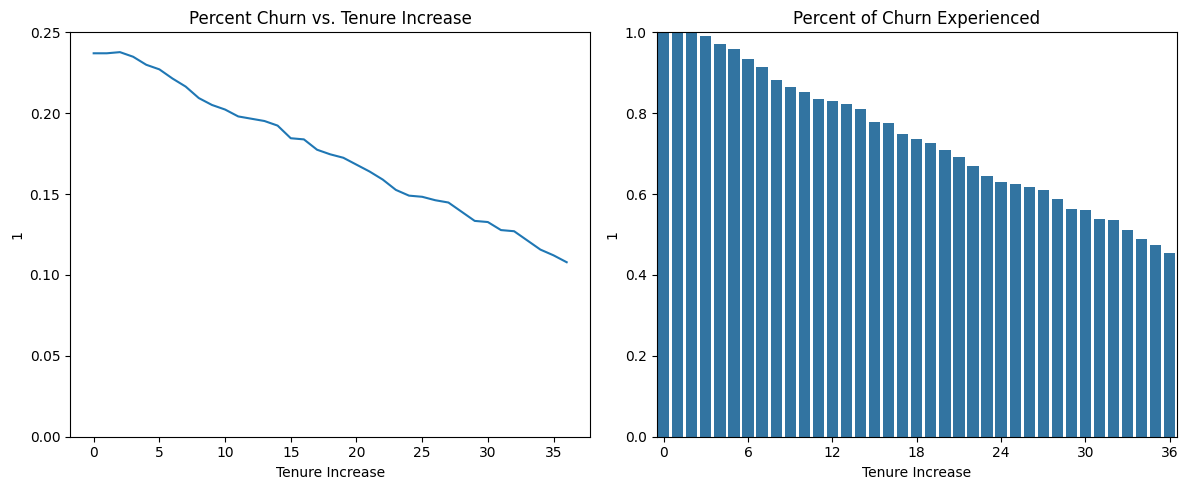

In [195]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.lineplot(x=[0] + tenures_to_test, y=outcome.loc[1,:], ax=ax[0])
ax[0].set_title('Percent Churn vs. Tenure Increase')
ax[0].set_xlabel('Tenure Increase')
ax[0].set_ylim(0, 0.25)

sns.barplot(x=[0] + tenures_to_test, y=outcome.loc[1,:] / outcome.iloc[1,0])
ax[1].set_title('Percent of Churn Experienced')
ax[1].set_ylim(0, 1)
ax[1].set_xticks([0, 6, 12, 18, 24, 30, 36])
ax[1].set_xlabel('Tenure Increase')

fig.tight_layout();

In [136]:
discount_test = pd.concat([test.loc[test['MonthlyCharges'] < 62, 'Churn'].value_counts(normalize=True),
                           test.loc[test['MonthlyCharges'] >= 62, 'Churn'].value_counts(normalize=True)], axis=1)
discount_test.columns = ['price1', 'price2']
discount_test

,price1,price2
Churn,,
No,0.843902,0.68262
Yes,0.156098,0.31738


In [180]:
discounts_to_test = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

outcome = pd.Series(knn_cv.best_estimator_.predict(processed_test.drop(columns=['customerID', 'Target']))).value_counts(normalize=True)
outcome.name = '0%'
for discount in discounts_to_test:
  discounted_test = test.copy()
  discounted_test['MonthlyCharges'] = discounted_test['MonthlyCharges'] * (1 - discount)
  discounted_test = preprocess_data(discounted_test)
  discounted_pred = knn_cv.best_estimator_.predict(discounted_test.drop(columns=['customerID', 'Target']))
  discounted_outcome = pd.Series(discounted_pred).value_counts(normalize=True)
  discounted_outcome.name = f'{discount*100}%'
  outcome = pd.concat([outcome, discounted_outcome], axis=1)

In [181]:
outcome

,0%,10.0%,20.0%,30.0%,40.0%,50.0%,60.0%,70.0%,80.0%,90.0%,100%
0,0.762952,0.764372,0.780696,0.797729,0.814762,0.84528,0.874379,0.914833,0.959546,0.980128,0.982967
1,0.237048,0.235628,0.219304,0.202271,0.185238,0.15472,0.125621,0.085167,0.040454,0.019872,0.017033


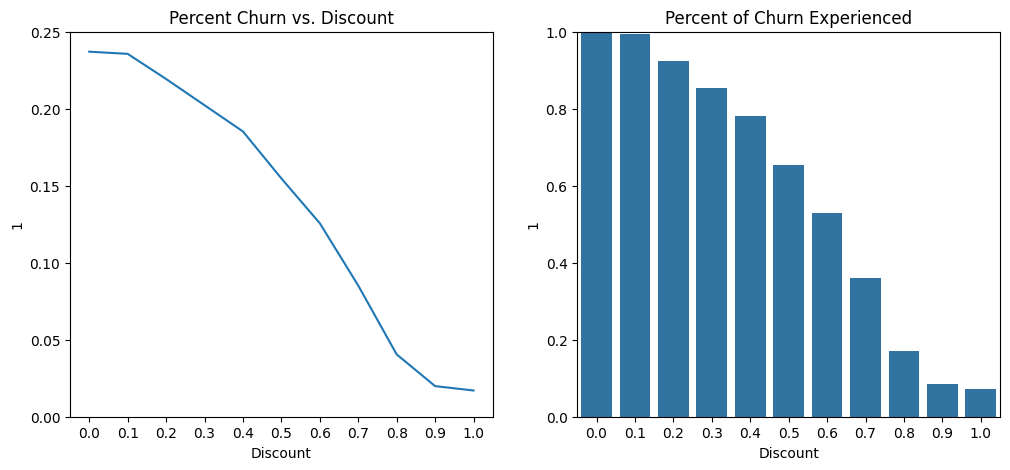

In [182]:
fig, ax = plt.subplots(ncols=2, figsize=(12,5))
sns.lineplot(x=[0] + discounts_to_test, y=outcome.loc[1,:], ax=ax[0])
ax[0].set_title('Percent Churn vs. Discount')
ax[0].set_xticks([0] + discounts_to_test)
ax[0].set_xlabel('Discount')
ax[0].set_ylim(0, 0.25)

sns.barplot(x=[0] + discounts_to_test, y=outcome.loc[1,:] / outcome.iloc[1,0])
ax[1].set_title('Percent of Churn Experienced')
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Discount');

In [128]:
test[['Churn', 'InternetService']].groupby('Churn').value_counts()

Churn  InternetService
No     DSL                400
       Fiber optic        374
       No                 287
Yes    Fiber optic        243
       DSL                 87
       No                  18
Name: count, dtype: int64

In [129]:
test[['Churn', 'Contract']].groupby('Churn').value_counts()

Churn  Contract      
No     Month-to-month    456
       Two year          341
       One year          264
Yes    Month-to-month    315
       One year           23
       Two year           10
Name: count, dtype: int64